# Databse Application using SQLAlchemy

## Description
Managing real estate sales and listing using SQLAlchemy. The App contains the schema in ```create.py``` for building the tables needed as well as the relational joints between them given the standards of SQL normalization. Then the file ```insert_data.py``` serves as an example of feeding data into the database which then form a reference for the queries performed by ```query_data.py``` file. Finally, the unit testing section is run by ```test.py```.

## Running instructions
As mentioned in the assigment description, the app runs as follow:
```bash
python3.6 -m venv .venv  
source .venv/bin/activate   
pip3 install -r requirements.txt  
python3 create.py  
python3 insert_data.py  
python3 query_data.py  
python3 test.py  
```

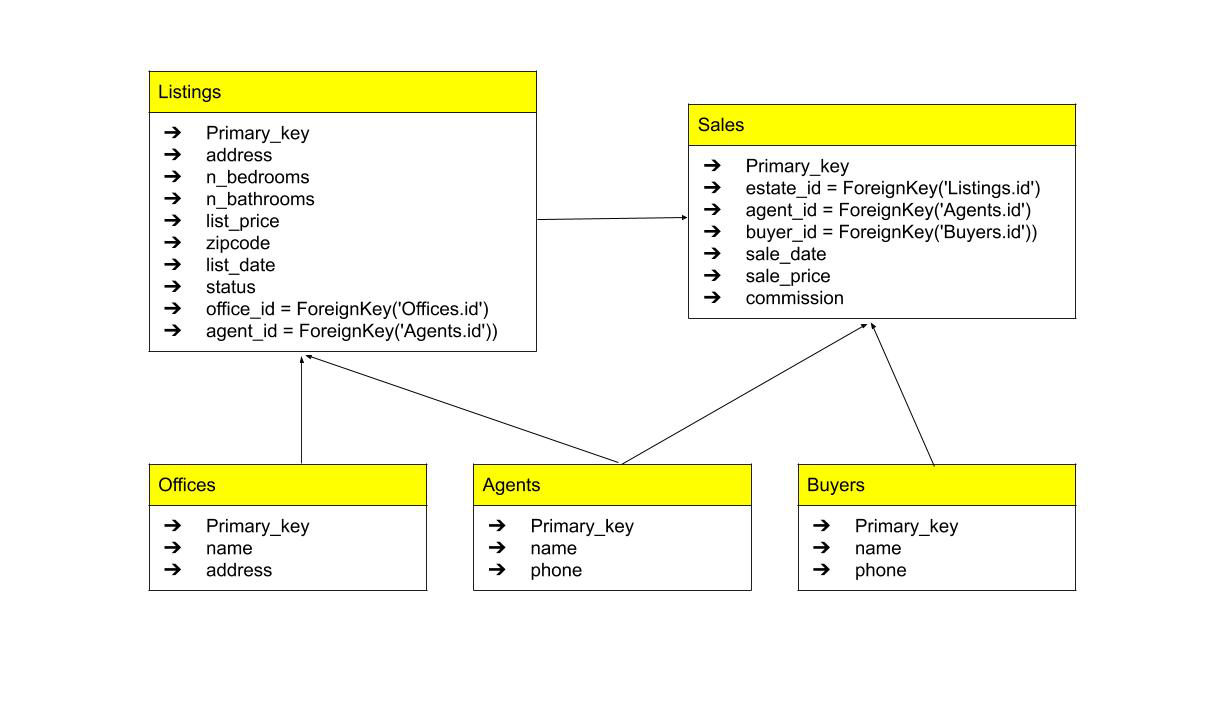

In [1]:
from PIL import Image
Image.open('relational table.jpg')

## create.py

In [2]:
# Importing packages

from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship, sessionmaker
from datetime import datetime as dt
from sqlalchemy import*
import numpy as np
import pandas as pd

In [3]:
# Create an engine and a declarative bases

engine = create_engine('sqlite:///:memory:', echo = False)
#engin = create_engine('sqlite:///database.db')
engine.connect()
Base = declarative_base()

In [4]:
# CREATING TABLES AND THEIR ATTRIBUTES
'''
All the relevant details of that house need to be captured, ie. at least: 
seller details, # of bedrooms, # of bathrooms, listing price, zip code, 
date of listing, the listing estate agent, and the appropriate office.
'''
class Property(Base):
    __tablename__ = 'Listings'
    id = Column(Integer, primary_key = True)
    address = Column(Text)
    n_bedrooms = Column(Integer)
    n_bathrooms = Column(Integer)
    list_price = Column(Integer)
    zipcode = Column(Integer)
    list_date = Column(Date)
    status = Column(Text)   
    office_id = Column(Integer, ForeignKey('Offices.id'))
    agent_id = Column(Integer, ForeignKey('Agents.id'))    

class Agent(Base):
    __tablename__ = 'Agents'
    id = Column(Integer, primary_key = True)
    name = Column(Text)
    phone = Column(Text)
    
class Office(Base):
    __tablename__ = 'Offices'
    id = Column(Integer, primary_key = True)
    name = Column(Text)
    address = Column(Text)

class Buyer(Base):
    __tablename__ = 'Buyers'
    id = Column(Integer, primary_key = True)
    name = Column(Text)
    phone = Column(Text)   
    
'''
All appropriate details related to the sale must be captured, ie. at least: 
buyer details, sale price, date of sale,the selling estate agent.
'''
class Sale(Base):
    __tablename__ = 'Sales'
    id = Column(Integer, primary_key = True)
    estate_id = Column(Integer, ForeignKey('Listings.id'))
    agent_id = Column(Integer, ForeignKey('Agents.id'))
    buyer_id = Column(Integer, ForeignKey('Buyers.id'))
    sale_date = Column(Date)
    sale_price = Column(Integer)
    commission = Column(Integer)

Base.metadata.create_all(bind=engine)

In [5]:
def sold_property(estate, agent, buyer, date):
    '''
    The function is called whenever we wish to record a sale.
    It takes the property_id, agent_id, buyer_id, data as input
    '''
    Session = sessionmaker(bind=engine)
    session = Session()
    
    # Compute the comission based on the property price
    sold_price = session.query(Property.list_price).filter(Property.id == estate)
    # List the range of prices and their respective commission rates
    price_range = [10**5, 2*10**5, 5*10**5, 10**6, np.inf]
    rate = [.01, .075, .06, .05, .04]
    # List the possible cases for the commission rates
    cases = case([(Property.list_price < price_range[i], rate[i]) 
                  for i in range(len(price_range))])
    
    # Insert the commission based on the 
    commission = session.query(Property.list_price*cases)\
                .filter(Property.id == estate)
    
    # Add the property into the Sales table along with the attriibutes
    session.add(Sale(estate_id = estate, agent_id = agent, sale_date = date,
                     sale_price = sold_price, commission = commission))
    
    # Update the status of the property as SOLD
    sold_estate = session.query(Property).filter(Property.id == estate)
    sold_estate.update({Property.status: 'SOLD'})
    
    # Commit the changes and close the session
    session.commit()
    session.close()

## insert_data.py

In [6]:
# INSERT DATA INTO THE DATABASE

# Open the session
Session = sessionmaker(bind=engine)
session = Session()

list_property = [
    # address, bedrooms, bathrooms, price, zipcode, date, status, office_id, agent_id
    ['Property1', 9, 3, 1500000, 94102, dt(2020, 3, 9), 'ON SALE', 1, 4],
    ['Property2', 4, 2, 700000, 94105, dt(2020, 2, 16), 'ON SALE', 3, 2],
    ['Property3', 2, 3, 400000, 94106, dt(2020, 3, 11), 'ON SALE', 2, 6],
    ['Property4', 4, 2, 175000, 94102, dt(2020, 2, 19), 'ON SALE', 4, 7],
    ['Property5', 5, 2, 300000, 94103, dt(2020, 1, 21), 'ON SALE', 4, 1],
    ['Property6', 6, 1, 80000, 94105, dt(2020, 1, 26), 'ON SALE', 7, 5],
    ['Property7', 4, 2, 90000, 94103, dt(2020, 2, 26), 'ON SALE', 3, 2]]

list_office = [
               # office_name, office_address
               ['Office1', '1412 Market st'],
               ['Office2', '851 Nob Hill'],
               ['Office3', '458 Powel st'],
               ['Office4', '1145 Market st'],
               ['Office5', '855 Nob Hill'],
               ['Office6', '745 Van Ness'],
               ['Office7', '935 Van Ness']]

list_agent = [
              # agent_name, phone
              ['Agent1','415-678-0001'],
              ['Agent2','415-678-0002'],
              ['Agent3','415-678-0003'],
              ['Agent4','415-678-0004'],
              ['Agent5','415-678-0005'],
              ['Agent6','415-678-0006'],
              ['Agent7','415-678-0007']]

list_buyer = [
              # buyer_name, phone
              ['Buyer1','415-678-1000'],
              ['Buyer2','415-678-2000'],
              ['Buyer3','415-678-3000'],
              ['Buyer4','415-678-4000'],
              ['Buyer5','415-678-5000'],
              ['Buyer6','415-678-6000'],
              ['Buyer7','415-678-7000']]


# Compile the list into a distionaries with attributes as keys
classes = [Property, Office, Agent, Buyer]
lists = [list_property, list_office, list_agent, list_buyer]
columns = [Class.__table__.columns.keys()[1:] for Class in classes]

for i in range(len(classes)):
    temp = []
    for item in lists[i]:
        items = dict(zip(columns[i], item))
        temp.append(items)
    # Add entries for each table
    for t in temp:
        session.add(classes[i](**t))
        
# Commit the changes and close the session
session.commit()
session.close()

In [7]:
# ENTER THE DATA ON SOLD PROPERTIES
# estate, agent, buyer, date
sold_property(1, 5, 2, dt(2020, 3, 19))
sold_property(2, 4, 5, dt(2020, 4, 5))
sold_property(3, 4, 1, dt(2020, 3, 25))
sold_property(4, 7, 6, dt(2020, 3, 29))
sold_property(5, 6, 3, dt(2020, 4, 1))
sold_property(6, 3, 4, dt(2020, 4, 3))
sold_property(7, 6, 7, dt(2020, 3, 21))

## query_data.py

In [8]:
# Query 1: Find the top 5 offices with the most sales for that month

sales_count = func.count(Property.office_id).label('Sales')
q1 = session.query(Property.office_id, Office.name, Office.address, sales_count)\
    .join(Office).filter(Property.status == 'SOLD')\
    .group_by(Property.office_id)\
    .order_by(sales_count.desc()).limit(5)

print('Top 5 offices with the most sales for that month: ')
pd.read_sql(q1.statement, session.bind)

Top 5 offices with the most sales for that month: 


office_id     name         address  Sales
0          3  Office3    458 Powel st      2
1          4  Office4  1145 Market st      2
2          1  Office1  1412 Market st      1
3          2  Office2    851 Nob Hill      1
4          7  Office7    935 Van Ness      1

In [9]:
# Query 2: Find the top 5 estate agents who have sold the most

agent_sale_count = func.count(Property.agent_id).label('Sales')
q2 = session.query(Agent.id, Agent.name, Agent.phone, agent_sale_count)\
    .join(Property).filter(Property.status == 'SOLD')\
    .group_by(Agent.id).order_by(agent_sale_count.desc()).limit(5)

print('Top 5 estate agents who have sold the most: ')
pd.read_sql(q2.statement, session.bind)

Top 5 estate agents who have sold the most: 


id    name         phone  Sales
0   2  Agent2  415-678-0002      2
1   1  Agent1  415-678-0001      1
2   4  Agent4  415-678-0004      1
3   5  Agent5  415-678-0005      1
4   6  Agent6  415-678-0006      1

In [10]:
# Query 3: Calculate the commission that each estate agent must receive

total_coms = func.sum(Sale.commission).label('Commission')
q3 = session.query(Agent.name, Agent.phone, total_coms)\
    .join(Property, Property.agent_id == Agent.id)\
    .join(Sale, Sale.estate_id == Property.id)\
    .group_by(Agent.id)

print('The commission that each estate agent must receive: ')
pd.read_sql(q3.statement, session.bind)

The commission that each estate agent must receive: 


name         phone  Commission
0  Agent1  415-678-0001       18000
1  Agent2  415-678-0002       35900
2  Agent4  415-678-0004       60000
3  Agent5  415-678-0005         800
4  Agent6  415-678-0006       24000
5  Agent7  415-678-0007       13125

In [11]:
# Query 4: For all houses that were sold that month, 
# calculate the average number of days that the houses were on the market.

begin = pd.read_sql(session.query(Property.list_date)\
                    .join(Sale).filter(Property.status == 'SOLD')\
                    .statement, session.bind)

end = pd.read_sql(session.query(Sale.sale_date).statement, session.bind)

duration = np.mean([(end['sale_date'][i] - begin['list_date'][i]).days 
                    for i in range(len(end))])
print('The average number of days that the houses were on the market: ',
      round(duration, 0))

The average number of days that the houses were on the market:  39.0


In [12]:
# Query 5: For all houses that were sold that month, calculate the average selling price

avg_price = func.avg(Sale.sale_price).label('Average Price')
q5 = session.query(avg_price)\
    .filter(extract('month', Sale.sale_date) == dt.today().month)

print('The average selling price in the current month: ',
      pd.read_sql(q5.statement, session.bind).values[0][0])

The average selling price in the current month:  360000.0


In [13]:
# Query 6: Find the zip codes with the top 5 average sales prices

avg_price = func.avg(Sale.sale_price).label('Average Price')
q6 = session.query(Property.zipcode, avg_price)\
    .join(Sale).filter(Property.status == 'SOLD')\
    .group_by(Property.zipcode)\
    .order_by(avg_price.desc()).limit(5)

print('The zip codes with the top 5 average sales prices: ')
pd.read_sql(q6.statement, session.bind)

The zip codes with the top 5 average sales prices: 


zipcode  Average Price
0    94102       837500.0
1    94106       400000.0
2    94105       390000.0
3    94103       195000.0

## test.py

In [14]:
import unittest

# CREATING A CLASS FOR UNIT TESTING
class InsertTestCase(unittest.TestCase):
    
    engine = create_engine('sqlite:///:memory:')
    #engin = create_engine('sqlite:///test.db')
    engine.connect()
    # Inserting fake data (as if the original one was not)
    test_agents = [['test_agent1', '415-123-4567'],
                   ['test_agent2', '415-123-5678'],
                   ['test_agent3', '415-123-6789']]

    test_offices = [['test_office1', '5th Ave'],
                    ['test_office2', '6th Ave'],
                    ['test_office3', '7th Ave']]

    test_buyers = [['test_buyer1','415-678-1111'],
                   ['test_buyer2','415-678-2222'],
                   ['test_buyer3','415-678-3333']]

    test_properties = [['test_property1', 5, 2, 100, 94102, 
                        dt(2020, 3, 15), 'ON SALE', 1, 2],
                       ['test_property2', 6, 2, 200, 94103, 
                        dt(2020, 3, 8), 'ON SALE', 2, 3],
                       ['test_property3', 2, 1, 100, 94102, 
                        dt(2020, 3, 3), 'ON SALE', 3, 1]]
    
    # Adding the data into the database
    for i in range(3):
        session.add(Agent(**dict(zip(Agent.__table__.columns.keys()[1:], 
                                     test_agents[i]))))
        session.add(Office(**dict(zip(Office.__table__.columns.keys()[1:], 
                                      test_offices[i]))))
        session.add(Buyer(**dict(zip(Buyer.__table__.columns.keys()[1:], 
                                     test_buyers[i]))))
        session.add(Property(**dict(zip(Property.__table__.columns.keys()[1:], 
                                        test_properties[i]))))  
        
    # Testing the insertion of data in all tables
    def test_insert_agent(self):
        test_query = session.query(Agent)\
        .filter_by(name='test_agent2', phone='415-123-5678').first()
        self.assertTrue(test_query.name == 'test_agent2')

    def test_insert_office(self):
        test_query = session.query(Office)\
        .filter_by(name='test_office1', address='5th Ave').first()
        self.assertTrue(test_query.address == '5th Ave')

    def test_insert_property(self):
        test_query = session.query(Property)\
        .filter_by(address='test_property1').first()
        self.assertTrue(test_query.status == 'ON SALE')


if __name__ == '__main__':
    unittest.main(argv=[''], verbosity=2, exit=False)

test_insert_agent (__main__.InsertTestCase) ... ok
test_insert_office (__main__.InsertTestCase) ... ok
test_insert_property (__main__.InsertTestCase) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.009s

OK
